# ***Mount Google Drive***

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


# ***IMPORT LIBRARIES***

In [ ]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

***SET SEED TO REPLICATE THIS NOTEBOOK***

In [ ]:
torch.manual_seed(111)

***define transform, a function to load the data***






In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

***DEFINE WORKING DIRECTORY WHERE TRAINING DATA WILL BE DOWNLOADED***

In [ ]:
%cd '/content/gdrive/MyDrive/GAN_numbers_MNIST/'

/content/gdrive/MyDrive/GAN_numbers_MNIST


***load the training data and perform the conversions using transform***

In [ ]:
train_set = torchvision.datasets.MNIST(root=".", train=True, download=True, transform=transform)

0it [00:00, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


0it [00:00, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


0it [00:00, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


0it [00:00, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


***create the data loader***

In [ ]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

***Matplotlib to plot some samples of the training data***

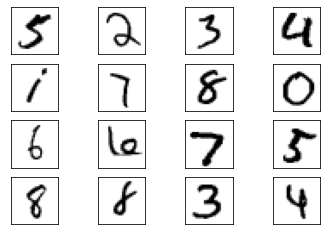

In [ ]:
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

# ***Implementing the Discriminator and the Generator***

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output

In [ ]:
discriminator = Discriminator()

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

generator = Generator()

# ***Training the Models***

In [ ]:
lr = 0.0001
num_epochs = 50
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [ ]:
for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples = real_samples
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, 100))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels
        )
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100))

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.584979772567749
Epoch: 0 Loss G.: 0.471470445394516
Epoch: 1 Loss D.: 0.1015171930193901
Epoch: 1 Loss G.: 4.796675682067871
Epoch: 2 Loss D.: 0.25499382615089417
Epoch: 2 Loss G.: 10.03479290008545
Epoch: 3 Loss D.: 0.008328228257596493
Epoch: 3 Loss G.: 5.829464435577393
Epoch: 4 Loss D.: 0.0653047263622284
Epoch: 4 Loss G.: 3.5275962352752686
Epoch: 5 Loss D.: 0.09080976247787476
Epoch: 5 Loss G.: 5.395679473876953
Epoch: 6 Loss D.: 0.11406494677066803
Epoch: 6 Loss G.: 2.9652018547058105
Epoch: 7 Loss D.: 0.2527144253253937
Epoch: 7 Loss G.: 3.2200968265533447
Epoch: 8 Loss D.: 0.3858260214328766
Epoch: 8 Loss G.: 2.7268753051757812
Epoch: 9 Loss D.: 0.2097635120153427
Epoch: 9 Loss G.: 2.031801223754883
Epoch: 10 Loss D.: 0.45748043060302734
Epoch: 10 Loss G.: 1.6616721153259277
Epoch: 11 Loss D.: 0.4958221912384033
Epoch: 11 Loss G.: 1.8721824884414673
Epoch: 12 Loss D.: 0.2916904091835022
Epoch: 12 Loss G.: 1.9357640743255615
Epoch: 13 Loss D.: 0.472580730915

# ***Checking the Samples Generated by the GAN***

In [ ]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
generated_samples = generator(latent_space_samples)

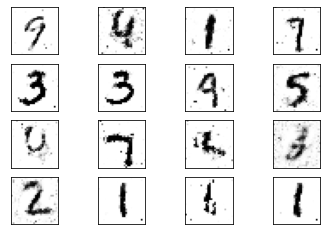

In [ ]:
generated_samples = generated_samples.detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])